Simple DNN with direct code with out any feature processing

In [1]:
import ktrain
import pandas as pd
from ktrain import tabular
import numpy as np
import pandas   as pd
from sklearn.utils import shuffle
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
def get_model(a,project):
    # load the model
    df = pd.read_csv(f'../data/{project}_combined.csv')
    # drop all rows in df
    df = df.drop(df.index)
    print(df.shape)
    for p,u in a.items():
        if p == project:
            continue
        df1 = pd.read_csv(f'../data/{p}_combined.csv')
        df = pd.concat([df,df1])
    df = df.drop(columns=['access_modifier','return_type','method_name','parameters','comments','returns'],axis=1)
    # Count the number of rows in the "not_smell" class
    # not_smell_count = (df['catagory'] == 'not_smell').sum()

    # # Calculate the number of rows to drop (one-third of the count)
    # rows_to_drop = not_smell_count // 3

    # # Filter the DataFrame to exclude one-third of the "not_smell" class
    # filtered_smell = df[df['catagory'] == 'not_smeel'].sample(frac=(1/3))  # Selecting 2/3 of 'not_smell' instances
    # # print(filtered_smell.shape)
    
    # defalut_smell = df[df['catagory'] != 'not_smeel']
    # print(defalut_smell.shape)
    # df = pd.concat([filtered_smell, defalut_smell])
    
    train_df = shuffle(df)
    test_df = pd.read_csv(f'../data/{project}_combined.csv')
    test_df = test_df.drop(columns=['access_modifier','return_type','method_name','parameters','comments','returns'],axis=1)
    # print(df['catagory'].value_counts())
    
    # df = df.sample(frac=1).reset_index(drop=True)
    
    # np.random.seed(42)
    # p = 0.1 # 10% for test set
    # prop = 1-p
    # temp_df = df.copy()
    # msk = np.random.rand(len(temp_df)) < prop
    # train_df = temp_df[msk]
    # test_df = temp_df[~msk]
    # print(train_df["label"].value_counts())
    # print(test_df["label"].value_counts())
    test_df['index'] = test_df.index
    train_df['index'] = train_df.index  
    return train_df, test_df

MCC is typically calculated for binary classification tasks. However, for multiclass classification, it can be computed as the geometric mean of the binary MCCs computed for each class against the rest. Let's adjust the code to compute MCC for each class against the rest without filtering:

In [3]:
def get_lean(train_df,test_df):
    print(test_df.iloc[1])
    trn,val,preproc = tabular.tabular_from_df(train_df, label_columns=['catagory'], random_state=42)
    model  = tabular.tabular_classifier(name='mlp',train_data=trn)
    learner = ktrain.get_learner(model,train_data=trn,val_data=val,batch_size=32)
    # learner.lr_find(show_plot=True, max_epochs=5)
    data = {"get":0,"is":1,"not_LA":2,"set":3}
    learner.fit_onecycle(5e-3, 1)
    print(learner.evaluate(val, class_names=preproc.get_classes()))
    predictor = ktrain.get_predictor(learner.model, preproc)


    preds = predictor.predict(test_df, return_proba=True)
    try:
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for class_name, class_idx in data.items():
            y_true_class = (test_df['catagory'] == class_name).astype(int)
            y_score_class = preds[:, class_idx]
            fpr[class_name], tpr[class_name], _ = roc_curve(y_true_class, y_score_class)
            roc_auc[class_name] = auc(fpr[class_name], tpr[class_name])
            
            
        # Plot ROC curve for each class
        plt.figure()
        for class_name, class_idx in data.items():
            plt.plot(fpr[class_name], tpr[class_name], label=f'ROC curve (AUC = {roc_auc[class_name]:0.2f}) for {class_name}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
        # Calculate AUC for each class

        auc_scores = []
        for class_name, class_idx in data.items():  # Iterate over each class
            y_true_class = (test_df['catagory'] == class_name).astype(int)  # Convert true labels to binary for the current class
            y_pred_class = preds[:, class_idx]  # Predicted probabilities for the current class
            
            # print(f'Class {class_name}:')
            # print('y_true_class:', y_true_class)
            # print('y_pred_class:', y_pred_class)
            
            auc_score = roc_auc_score(y_true_class, y_pred_class)  # Compute ROC AUC
            auc_scores.append(auc_score)
            # print(f'AUC for class {class_name}: {auc_score}')

        # Overall AUC can also be computed by averaging the AUC scores for each class
        overall_auc = np.mean(auc_scores)
        print(f'Overall AUC: {overall_auc}')
        # Calculate MCC for each class
        mcc_scores = []
        for class_name, class_idx in data.items():  # Iterate over each class
            y_true_class = (test_df['catagory'] == class_name).astype(int)  # True labels for the current class
            y_pred_class = np.argmax(preds, axis=1)  # Predicted labels for the current class
            
            # print(f'Class {class_name}:')
            # print('y_true_class:', y_true_class.shape)
            # print('y_pred_class:', y_pred_class.shape)
            
            # Filter y_pred_class to match the same samples as y_true_class
            y_pred_class_filtered = y_pred_class[test_df['catagory'] == class_name]
            # print(f"y_pred_class_filtered: {y_pred_class_filtered.shape}")
            mcc_score = matthews_corrcoef(y_true_class, y_pred_class)  # Compute MCC
            mcc_scores.append(mcc_score)
            print(f'MCC for class {class_name}: {mcc_score}')

        # Overall MCC can also be computed by averaging the MCC scores for each class
        overall_mcc = np.mean(mcc_scores)
        print(f'Overall MCC: {overall_mcc}')
        print(test_df.iloc[2])
        data = {"get":0,"is":1,"not_LA":2,"set":3}
        print("predict output is here")
        pred = predictor.predict(test_df[1:2])
        print(test_df.iloc[1])
        print(f"the prediction is {pred[0]} this")
        print()
        print()
        predictor.explain(test_df,row_num=1,class_id=data[pred[0]])
    except ValueError:
        print(f'ValueError {ValueError}')
    
    return predictor

In [4]:
def model_save(predictor,test_df,output_file):

    print()
    print()
    model_path = f'model/{output_file}_content_model'
    print(model_path)
    print()
    print()
    predictor.save(model_path)
    reloaded_predictor = ktrain.load_predictor(model_path)
    reloaded_predictor.predict(test_df)[:5]

the project is buildship
(0, 8)
content     public SignedEncryptedParts getSignedParts() {...
catagory                                               not_LA
index                                                       1
Name: 1, dtype: object
processing train: 142216 rows x 3 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
56672  0.0  0.0     1.0  0.0
84839  0.0  0.0     0.0  1.0
15024  1.0  0.0     0.0  0.0
86947  0.0  1.0     0.0  0.0
9322   1.0  0.0     0.0  0.0
processing test: 15637 rows x 3 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
8184   0.0  0.0     0.0  1.0
42878  0.0  0.0     1.0  0.0
3880   0.0  0.0     1.0  0.0
93119  0.0  0.0     1.0  0.0
60523  0.0  0.0     0.0  1.0
Is Multi-Label? False
done.


begin training using onecycle policy with max lr of 0.005...
489/489 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

         get       0.56      0.34      0.42      4364
          is

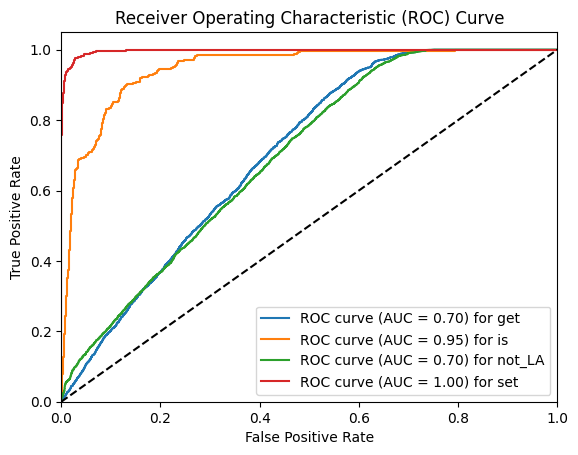

Overall AUC: 0.8366290574679729
MCC for class get: -0.0719908959867617
MCC for class is: 0.10575569052544166
MCC for class not_LA: -0.017302521985127165
MCC for class set: 0.058652943080850825
Overall MCC: 0.018778803908600906
content     public SecurityToken getToken(String id) { pro...
catagory                                               not_LA
index                                                       2
Name: 2, dtype: object
predict output is here
['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
1  0.0  0.0     1.0  0.0
content     public SignedEncryptedParts getSignedParts() {...
catagory                                               not_LA
index                                                       1
Name: 1, dtype: object
the prediction is not_LA this


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  1.0  0.0     0.0  0.0
2  1.0  0.0     0.0  0.0
3  1.0  0.0     0.0  0.0
4  1.0  0.0     0.0  0.0
4/4 [==============================] -

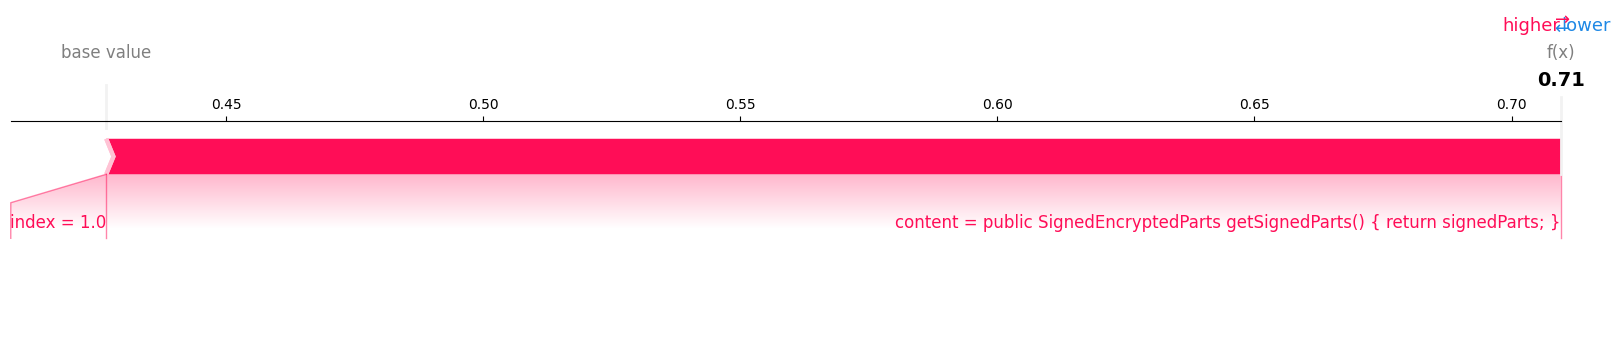



model/buildship_content_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  0.0  0.0     1.0  0.0
1  0.0  0.0     1.0  0.0
2  0.0  0.0     1.0  0.0
3  0.0  0.0     0.0  1.0
4  1.0  0.0     0.0  0.0
the project is eclips-collections
(0, 8)
content     { new RecursiveProcedure().value(2);  synchron...
catagory                                                   is
index                                                       1
Name: 1, dtype: object
processing train: 147083 rows x 3 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
34330  1.0  0.0     0.0  0.0
93150  0.0  0.0     0.0  1.0
6279   0.0  0.0     1.0  0.0
36576  1.0  0.0     0.0  0.0
67816  0.0  0.0     1.0  0.0
processing test: 16186 rows x 3 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
54494  0.0  0.0     1.0  0.0
2625   1.0  0.0     0.0  0.0
14589  0.0  0.0     0.0  1.0
71516  1.0  0.0     0.0  0.0
7826   0.0  1.0     0.0  0.0
Is Multi-Label? False
done.


begin training using onecycle policy with max l

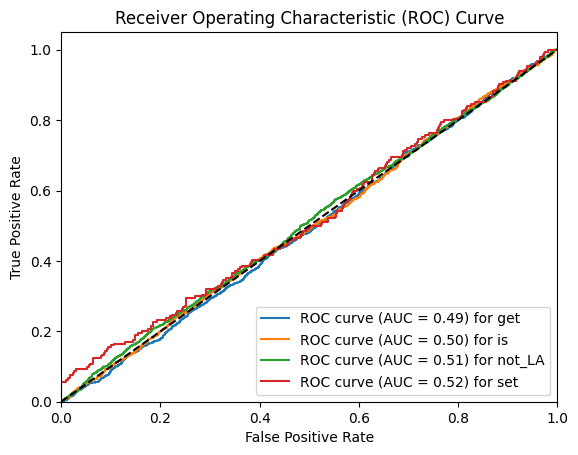

Overall AUC: 0.5045647322792697
MCC for class get: 0.0
MCC for class is: 0.0
MCC for class not_LA: 0.0
MCC for class set: 0.0
Overall MCC: 0.0
content     { return IS_EVEN; }
catagory                     is
index                         2
Name: 2, dtype: object
predict output is here
['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
1  0.0  1.0     0.0  0.0
content     { new RecursiveProcedure().value(2);  synchron...
catagory                                                   is
index                                                       1
Name: 1, dtype: object
the prediction is not_LA this


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  1.0  0.0     0.0  0.0
2  1.0  0.0     0.0  0.0
3  1.0  0.0     0.0  0.0
4  1.0  0.0     0.0  0.0
4/4 [==============================] - 0s 8ms/step
Explanation for class = not_LA (row_num=1): 


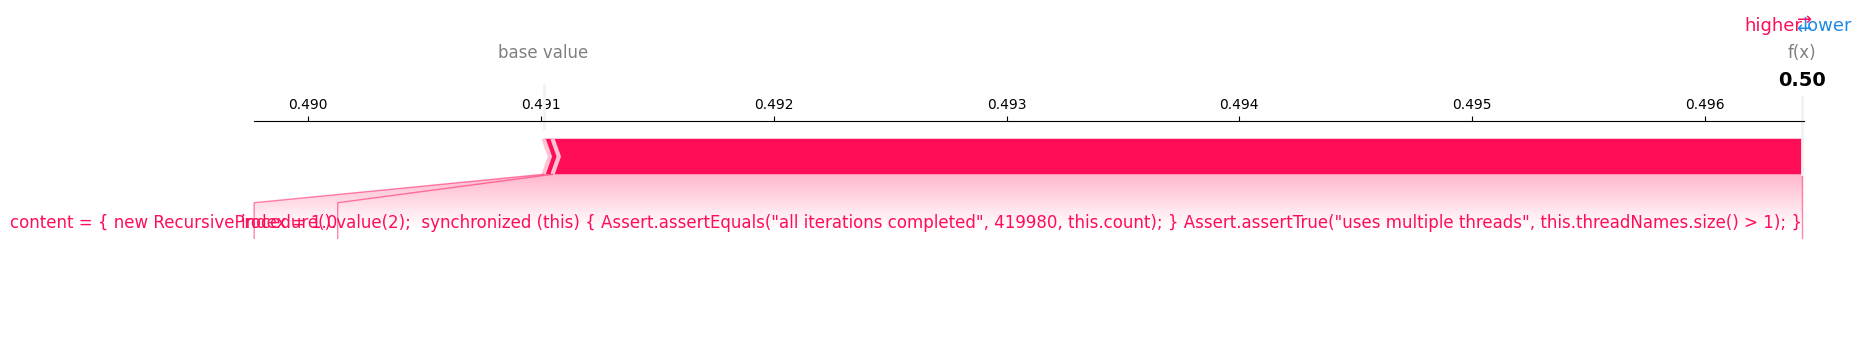



model/eclips-collections_content_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  0.0  1.0     0.0  0.0
2  0.0  1.0     0.0  0.0
3  0.0  0.0     1.0  0.0
4  0.0  0.0     1.0  0.0
the project is jifa
(0, 8)
content     public double getCauseInterval() { return caus...
catagory                                                  get
index                                                       1
Name: 1, dtype: object
processing train: 150763 rows x 3 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
24201  0.0  1.0     0.0  0.0
100    0.0  0.0     1.0  0.0
8838   1.0  0.0     0.0  0.0
18842  0.0  0.0     1.0  0.0
33506  1.0  0.0     0.0  0.0
processing test: 16601 rows x 3 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
9445   1.0  0.0     0.0  0.0
5953   0.0  0.0     1.0  0.0
83391  0.0  0.0     1.0  0.0
73729  0.0  1.0     0.0  0.0
77488  0.0  0.0     1.0  0.0
Is Multi-Label? False
done.


begin training using onecycle policy with max lr of 0.005...


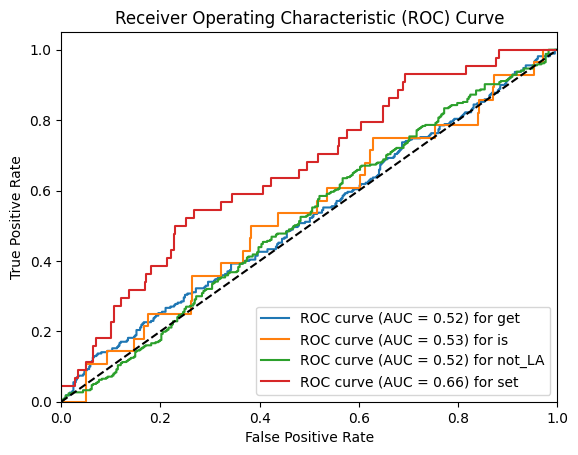

Overall AUC: 0.560274654874872
MCC for class get: 0.009016587746452141
MCC for class is: -0.05350981678730397
MCC for class not_LA: 0.01101599887221282
MCC for class set: 0.002921201136794673
Overall MCC: -0.007639007257961083
content     public int[] getObjectIds() { return ((IContex...
catagory                                                  get
index                                                       2
Name: 2, dtype: object
predict output is here
['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
1  1.0  0.0     0.0  0.0
content     public double getCauseInterval() { return caus...
catagory                                                  get
index                                                       1
Name: 1, dtype: object
the prediction is not_LA this


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  1.0  0.0     0.0  0.0
2  1.0  0.0     0.0  0.0
3  1.0  0.0     0.0  0.0
4  1.0  0.0     0.0  0.0
4/4 [==============================] -

divide by zero encountered in scalar divide


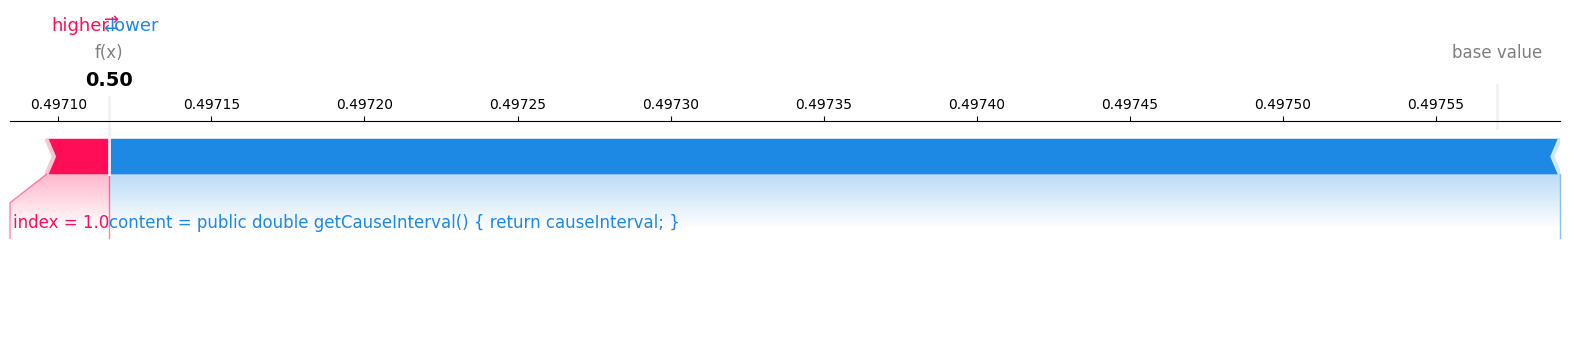



model/jifa_content_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  1.0  0.0     0.0  0.0
2  1.0  0.0     0.0  0.0
3  1.0  0.0     0.0  0.0
4  1.0  0.0     0.0  0.0
the project is jkube
(0, 8)
content     private ServicePort extractPortsFromImageSpec(...
catagory                                               not_LA
index                                                       1
Name: 1, dtype: object
processing train: 148810 rows x 3 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
67156  0.0  1.0     0.0  0.0
7420   0.0  0.0     0.0  1.0
18113  0.0  0.0     0.0  1.0
77585  0.0  0.0     1.0  0.0
12015  0.0  0.0     1.0  0.0
processing test: 16365 rows x 3 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
85710  1.0  0.0     0.0  0.0
15259  0.0  0.0     0.0  1.0
9072   1.0  0.0     0.0  0.0
27429  0.0  0.0     1.0  0.0
80216  0.0  1.0     0.0  0.0
Is Multi-Label? False
done.


begin training using onecycle policy with max lr of 0.005...

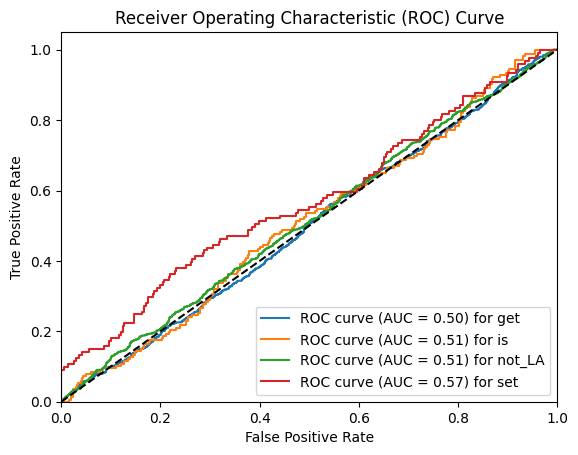

Overall AUC: 0.5227863560332263
MCC for class get: -0.007649155635538005
MCC for class is: 0.006676704295352223
MCC for class not_LA: -0.0012034125997006464
MCC for class set: 0.01402851728868119
Overall MCC: 0.0029631633371986904
content     public DebugService getDebugService() { return...
catagory                                                  get
index                                                       2
Name: 2, dtype: object
predict output is here
['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
1  0.0  0.0     1.0  0.0
content     private ServicePort extractPortsFromImageSpec(...
catagory                                               not_LA
index                                                       1
Name: 1, dtype: object
the prediction is not_LA this


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  1.0  0.0     0.0  0.0
2  1.0  0.0     0.0  0.0
3  1.0  0.0     0.0  0.0
4  1.0  0.0     0.0  0.0
4/4 [=============================

divide by zero encountered in scalar divide


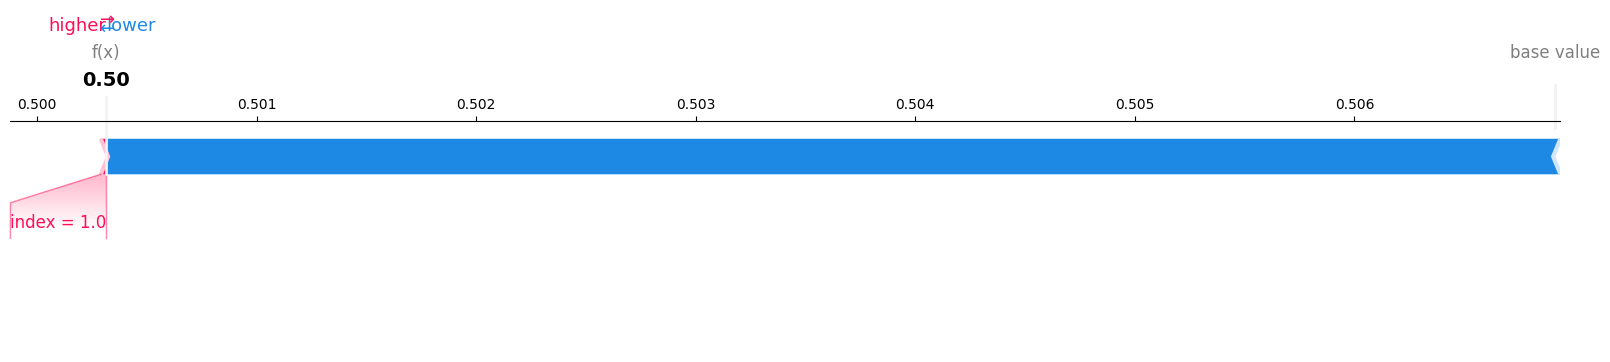



model/jkube_content_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  0.0  0.0     1.0  0.0
1  0.0  0.0     1.0  0.0
2  1.0  0.0     0.0  0.0
3  0.0  0.0     0.0  1.0
4  1.0  0.0     0.0  0.0
the project is hawkbit
(0, 8)
content     public RolloutGroupErrorCondition getErrorCond...
catagory                                                  get
index                                                       1
Name: 1, dtype: object
processing train: 149003 rows x 3 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
19479  0.0  1.0     0.0  0.0
16032  0.0  1.0     0.0  0.0
42390  1.0  0.0     0.0  0.0
6209   1.0  0.0     0.0  0.0
62595  1.0  0.0     0.0  0.0
processing test: 16388 rows x 3 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
53631  0.0  0.0     1.0  0.0
13088  0.0  1.0     0.0  0.0
34801  0.0  0.0     1.0  0.0
42755  0.0  0.0     0.0  1.0
6364   0.0  0.0     1.0  0.0
Is Multi-Label? False
done.


begin training using onecycle policy with max lr of 0.005.

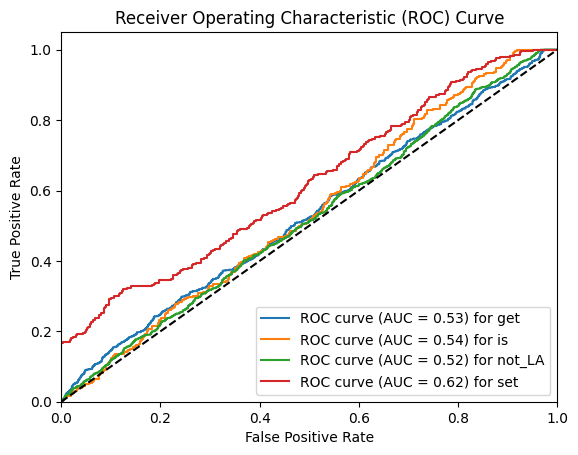

Overall AUC: 0.5522038598976365
MCC for class get: -0.00579235459023736
MCC for class is: 0.009058714418877003
MCC for class not_LA: -0.0033438934046321825
MCC for class set: 0.005062033251023218
Overall MCC: 0.0012461249187576697
content     { this.id = id;  return 0;}
catagory                            set
index                                 2
Name: 2, dtype: object
predict output is here
['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
1  1.0  0.0     0.0  0.0
content     public RolloutGroupErrorCondition getErrorCond...
catagory                                                  get
index                                                       1
Name: 1, dtype: object
the prediction is not_LA this


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  1.0  0.0     0.0  0.0
2  1.0  0.0     0.0  0.0
3  1.0  0.0     0.0  0.0
4  1.0  0.0     0.0  0.0
4/4 [==============================] - 0s 3ms/step
Explanation for class = not_LA (row_num=1): 


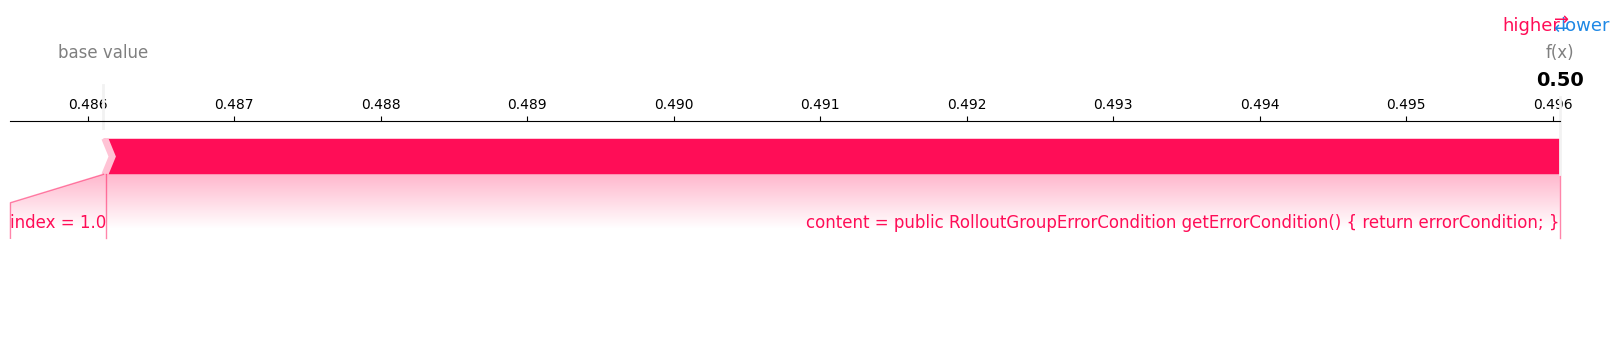



model/hawkbit_content_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  1.0  0.0     0.0  0.0
2  0.0  0.0     0.0  1.0
3  1.0  0.0     0.0  0.0
4  0.0  1.0     0.0  0.0
the project is kura
(0, 8)
content     public NetInterfaceType getType() { return Net...
catagory                                               not_LA
index                                                       1
Name: 1, dtype: object
processing train: 132267 rows x 3 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
77157  0.0  0.0     1.0  0.0
21654  0.0  1.0     0.0  0.0
71084  0.0  0.0     1.0  0.0
9472   1.0  0.0     0.0  0.0
249    0.0  0.0     1.0  0.0
processing test: 14513 rows x 3 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
305    1.0  0.0     0.0  0.0
26257  1.0  0.0     0.0  0.0
55158  0.0  0.0     1.0  0.0
17976  0.0  0.0     1.0  0.0
55049  0.0  0.0     1.0  0.0
Is Multi-Label? False
done.


begin training using onecycle policy with max lr of 0.005...


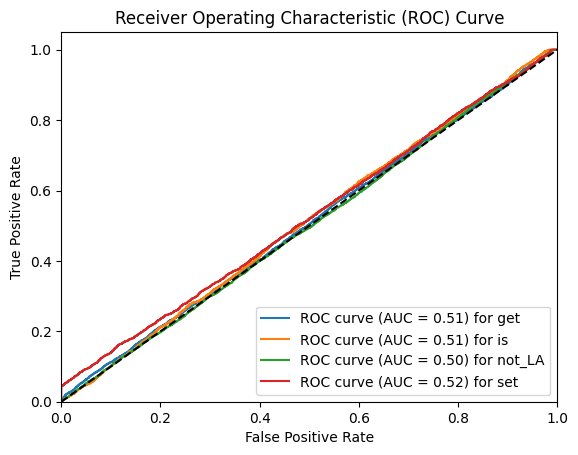

Overall AUC: 0.510766184312824
MCC for class get: -0.004026213175863426
MCC for class is: 0.0007967661353248709
MCC for class not_LA: -0.001042259533210303
MCC for class set: 0.005903772421020996
Overall MCC: 0.00040801646181803453
content     public String getFactoryPid() { return FACTORY...
catagory                                                  get
index                                                       2
Name: 2, dtype: object
predict output is here
['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
1  0.0  0.0     1.0  0.0
content     public NetInterfaceType getType() { return Net...
catagory                                               not_LA
index                                                       1
Name: 1, dtype: object
the prediction is not_LA this


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  1.0  0.0     0.0  0.0
2  1.0  0.0     0.0  0.0
3  1.0  0.0     0.0  0.0
4  1.0  0.0     0.0  0.0
1/1 [============================

divide by zero encountered in scalar divide


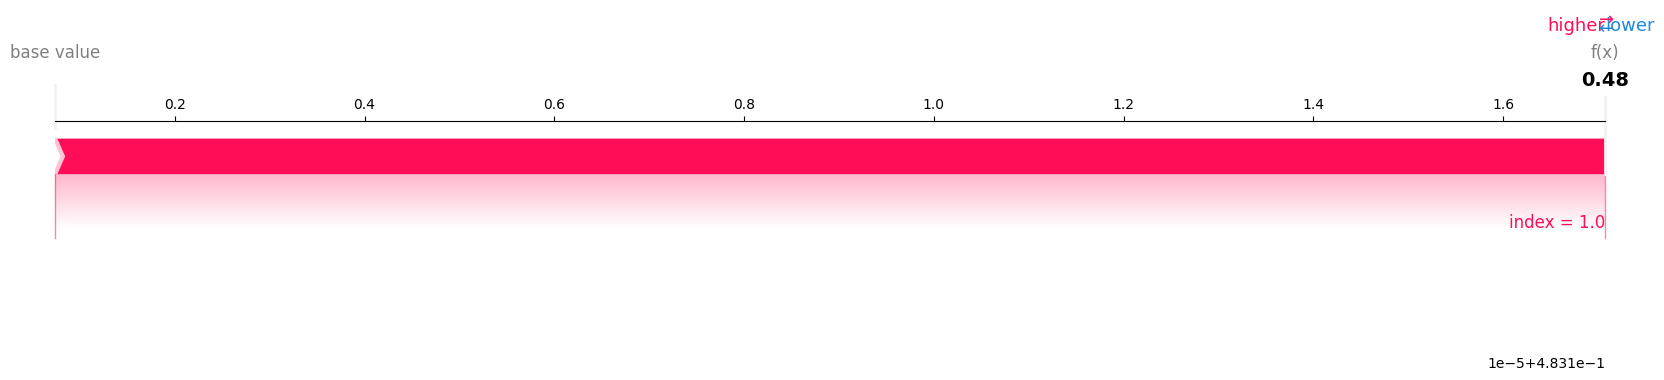



model/kura_content_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  0.0  0.0     1.0  0.0
2  1.0  0.0     0.0  0.0
3  0.0  0.0     1.0  0.0
4  0.0  0.0     1.0  0.0
the project is milo
(0, 8)
content     public PropertyTypeNode getReqTimesNode() thro...
catagory                                               not_LA
index                                                       1
Name: 1, dtype: object
processing train: 140421 rows x 3 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
45114  0.0  0.0     1.0  0.0
93111  0.0  0.0     1.0  0.0
51200  1.0  0.0     0.0  0.0
61132  0.0  0.0     1.0  0.0
982    1.0  0.0     0.0  0.0
processing test: 15446 rows x 3 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
78219  1.0  0.0     0.0  0.0
56049  0.0  0.0     1.0  0.0
3431   0.0  0.0     1.0  0.0
14453  1.0  0.0     0.0  0.0
68902  0.0  0.0     1.0  0.0
Is Multi-Label? False
done.


begin training using onecycle policy with max lr of 0.005...


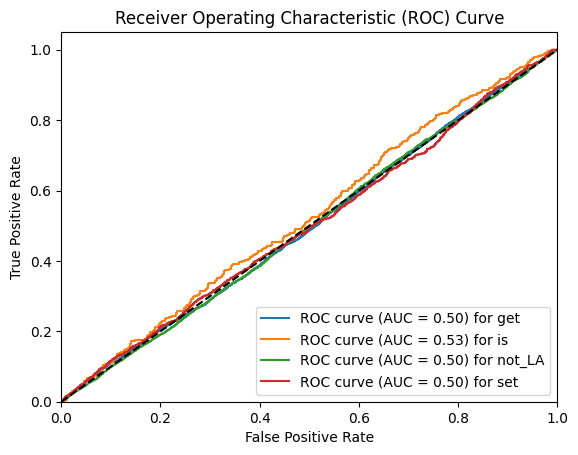

Overall AUC: 0.505698197126665
MCC for class get: -0.003589118676681913
MCC for class is: 0.0026300732170324325
MCC for class not_LA: -0.0003095209939780293
MCC for class set: 0.005083475657962943
Overall MCC: 0.0009537273010838584
content     public int getValue() { return value; }
catagory                                        get
index                                             2
Name: 2, dtype: object
predict output is here
['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
1  0.0  0.0     1.0  0.0
content     public PropertyTypeNode getReqTimesNode() thro...
catagory                                               not_LA
index                                                       1
Name: 1, dtype: object
the prediction is not_LA this


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  1.0  0.0     0.0  0.0
2  1.0  0.0     0.0  0.0
3  1.0  0.0     0.0  0.0
4  1.0  0.0     0.0  0.0
4/4 [==============================] - 0s 3ms/step
Explanation 

divide by zero encountered in scalar divide


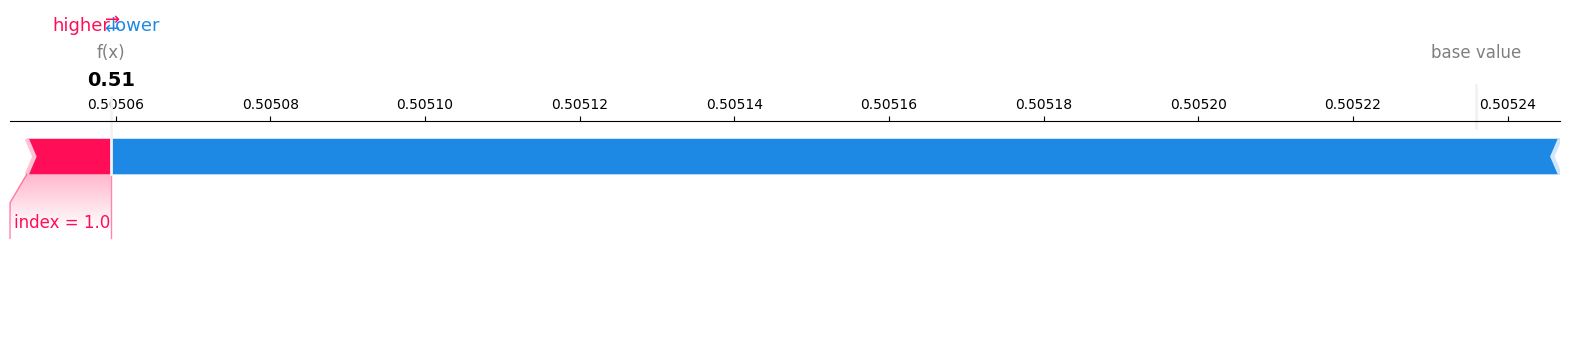



model/milo_content_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  0.0  0.0     1.0  0.0
2  1.0  0.0     0.0  0.0
3  0.0  0.0     1.0  0.0
4  1.0  0.0     0.0  0.0
the project is openvsx
(0, 8)
content     private AdminStatistics getReport(String token...
catagory                                               not_LA
index                                                       1
Name: 1, dtype: object
processing train: 149027 rows x 3 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
5530   1.0  0.0     0.0  0.0
15594  1.0  0.0     0.0  0.0
81719  0.0  0.0     1.0  0.0
5696   1.0  0.0     0.0  0.0
91310  0.0  0.0     1.0  0.0
processing test: 16393 rows x 3 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
12165  1.0  0.0     0.0  0.0
32441  0.0  0.0     1.0  0.0
719    1.0  0.0     0.0  0.0
1855   1.0  0.0     0.0  0.0
23200  1.0  0.0     0.0  0.0
Is Multi-Label? False
done.


begin training using onecycle policy with max lr of 0.005.

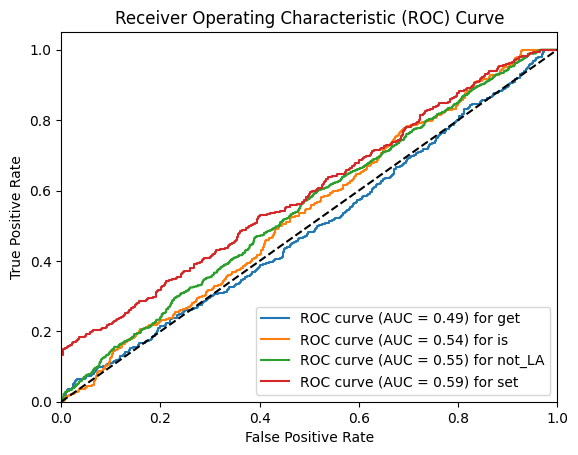

Overall AUC: 0.5447558283309134
MCC for class get: -0.0026431974501326012
MCC for class is: 0.004291908028268926
MCC for class not_LA: -0.0036666726360899413
MCC for class set: 0.004341304594171921
Overall MCC: 0.000580835634054576
content     { set(0, value);  return 0;}
catagory                             set
index                                  2
Name: 2, dtype: object
predict output is here
['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
1  0.0  0.0     1.0  0.0
content     private AdminStatistics getReport(String token...
catagory                                               not_LA
index                                                       1
Name: 1, dtype: object
the prediction is not_LA this


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  1.0  0.0     0.0  0.0
2  1.0  0.0     0.0  0.0
3  1.0  0.0     0.0  0.0
4  1.0  0.0     0.0  0.0
4/4 [==============================] - 0s 11ms/step
Explanation for class = not_LA (row_num=1): 

divide by zero encountered in scalar divide


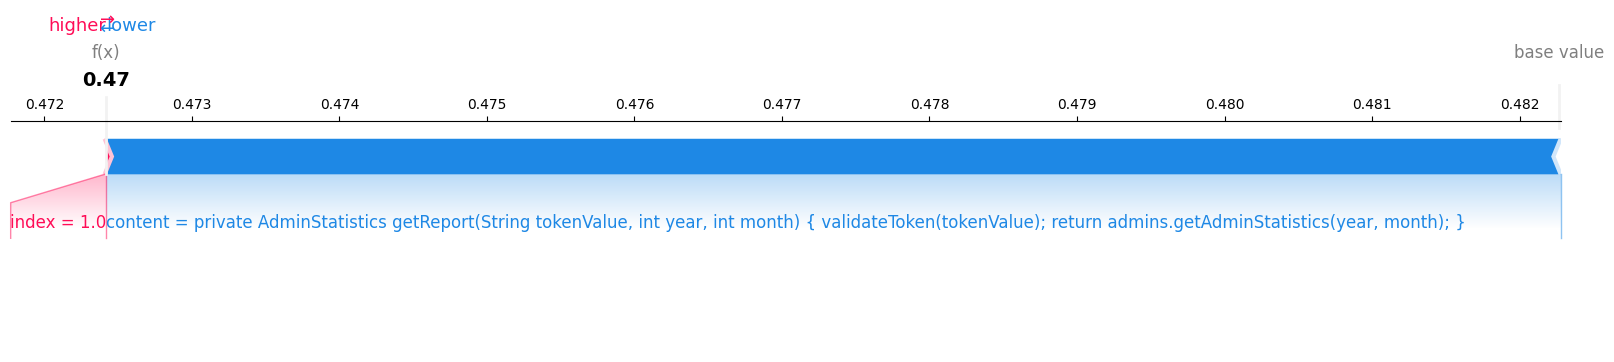



model/openvsx_content_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  0.0  0.0     1.0  0.0
1  0.0  0.0     1.0  0.0
2  0.0  0.0     0.0  1.0
3  0.0  1.0     0.0  0.0
4  0.0  0.0     1.0  0.0
the project is steady
(0, 8)
content     public String getContext() { return context; }
catagory                                            not_LA
index                                                    1
Name: 1, dtype: object
processing train: 140937 rows x 3 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
12512  0.0  0.0     1.0  0.0
30283  1.0  0.0     0.0  0.0
22858  0.0  0.0     1.0  0.0
2097   0.0  0.0     1.0  0.0
10430  0.0  0.0     1.0  0.0
processing test: 15506 rows x 3 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
60646  0.0  0.0     1.0  0.0
9362   1.0  0.0     0.0  0.0
38371  0.0  0.0     1.0  0.0
1694   0.0  0.0     1.0  0.0
9512   0.0  0.0     1.0  0.0
Is Multi-Label? False
done.


begin training using onecycle policy with max lr of 0.005...
485/485

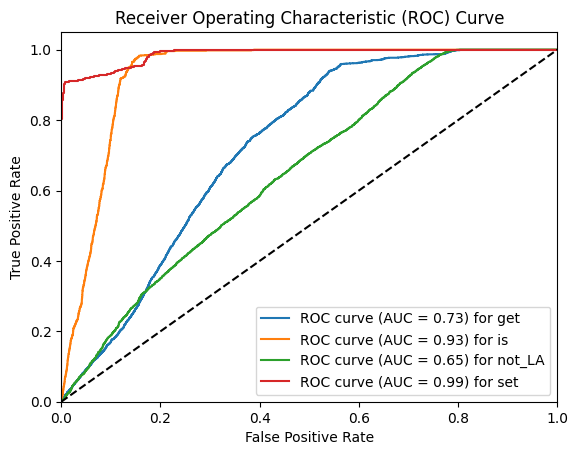

Overall AUC: 0.824855751547704
MCC for class get: -0.0635091686421928
MCC for class is: 0.09205364597938417
MCC for class not_LA: -0.04496156324351335
MCC for class set: 0.06656076776851452
Overall MCC: 0.012535920465548136
content     public QName getSymmetricBinding() { return SY...
catagory                                               not_LA
index                                                       2
Name: 2, dtype: object
predict output is here
['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
1  0.0  0.0     1.0  0.0
content     public String getContext() { return context; }
catagory                                            not_LA
index                                                    1
Name: 1, dtype: object
the prediction is not_LA this


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  1.0  0.0     0.0  0.0
2  1.0  0.0     0.0  0.0
3  1.0  0.0     0.0  0.0
4  1.0  0.0     0.0  0.0
4/4 [==============================] - 0s 5ms/step

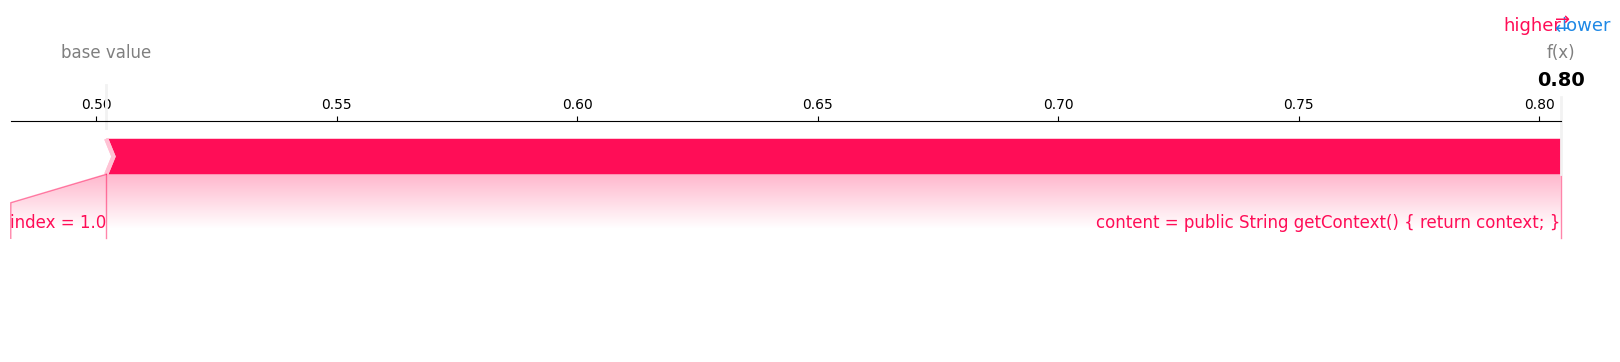



model/steady_content_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  0.0  0.0     1.0  0.0
1  0.0  0.0     1.0  0.0
2  0.0  0.0     1.0  0.0
3  0.0  0.0     0.0  1.0
4  0.0  0.0     1.0  0.0
the project is xtext
(0, 8)
content     @Test public void testRuleCall_01() throws Exc...
catagory                                                   is
index                                                       1
Name: 1, dtype: object
processing train: 62026 rows x 3 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
9078   1.0  0.0     0.0  0.0
6208   0.0  1.0     0.0  0.0
1311   0.0  0.0     1.0  0.0
20792  1.0  0.0     0.0  0.0
5047   0.0  1.0     0.0  0.0
processing test: 6799 rows x 3 columns
['get', 'is', 'not_LA', 'set']
       get   is  not_LA  set
19799  1.0  0.0     0.0  0.0
6859   0.0  0.0     1.0  0.0
338    1.0  0.0     0.0  0.0
16503  0.0  1.0     0.0  0.0
3072   1.0  0.0     0.0  0.0
Is Multi-Label? False
done.


begin training using onecycle policy with max lr of 0.005...
2

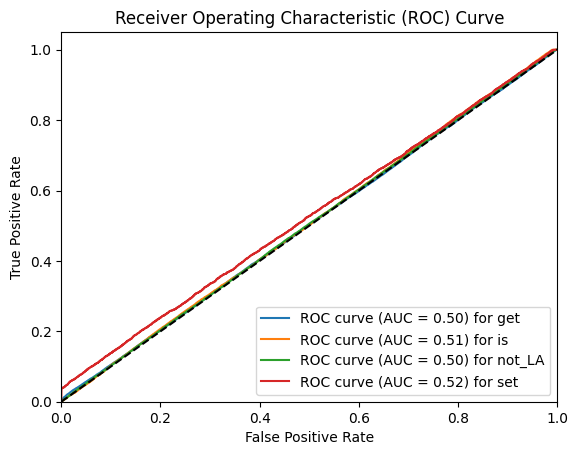

Overall AUC: 0.5088788237785652
MCC for class get: -0.0012280540502242927
MCC for class is: 0.000826427612220064
MCC for class not_LA: 0.0008482046097777224
MCC for class set: -0.0009131522351186154
Overall MCC: -0.00011664351583628042
content     public void setEcoreModel(String ecoreModel) {...
catagory                                               not_LA
index                                                       2
Name: 2, dtype: object
predict output is here
['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
1  0.0  1.0     0.0  0.0
content     @Test public void testRuleCall_01() throws Exc...
catagory                                                   is
index                                                       1
Name: 1, dtype: object
the prediction is not_LA this


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  1.0  0.0     0.0  0.0
1  1.0  0.0     0.0  0.0
2  1.0  0.0     0.0  0.0
3  1.0  0.0     0.0  0.0
4  1.0  0.0     0.0  0.0
1/1 [========================

divide by zero encountered in scalar divide


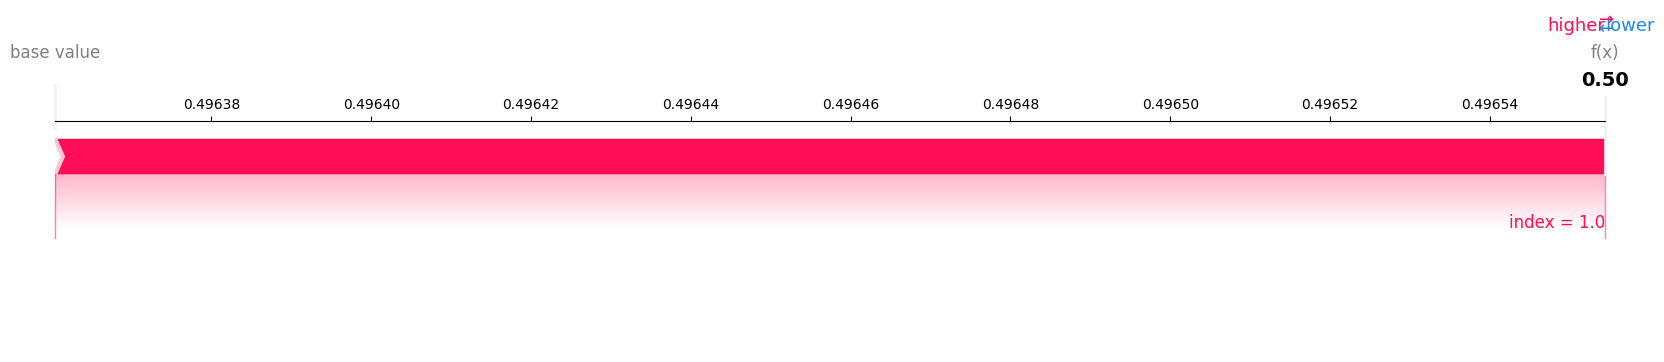



model/xtext_content_model




You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


['get', 'is', 'not_LA', 'set']
   get   is  not_LA  set
0  0.0  1.0     0.0  0.0
1  0.0  1.0     0.0  0.0
2  0.0  0.0     1.0  0.0
3  1.0  0.0     0.0  0.0
4  0.0  0.0     1.0  0.0


In [5]:
a = {
    "buildship": " ", 
    "eclips-collections": " ",
    "jifa": " ",
    "jkube": " ",
    "hawkbit": "https://github.com/eclipse/hawkbit.git",
    "kura": "https://github.com/eclipse/kura.git",
    "milo": "https://github.com/eclipse/milo.git",
    "openvsx": "https://github.com/eclipse/openvsx.git",
    "steady": "https://github.com/eclipse/steady.git",
    "xtext": "https://github.com/eclipse/xtext.git"
}
for project,url in a.items():
    print(f"the project is {project}")
    train_df,test_df = get_model(a,project)
    predictor = get_lean(train_df,test_df)
    model_save(predictor,test_df,project)